OSE Scientific Computing | Winter 2021, M.Sc. in Economics, University of Bonn | [Sona Verdiyeva](https://github.com/s6soverd) and [Abraham Raju](https://github.com/Abraham-newbie)

# Prediction of Crime Rates using Brightness derived from Nighttime Satellite Light Images - VIIRS

This notebook contains derivation of brightness index from [VIIRS Nighttime Satellite Light Images](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG), and with the addition of other control variables, the prediction of crime rates in the city of Portland, Oregano state in US. As far as the brightness index concerns, the index is derived for all the neighborhoods in the city of Portland, for which the crime rate datasets are available.

### Table of Contents 
* [1.Overview](#overview) 
* [2.VIIRS - Nighttime Satellite Light Images](#viirs) 
* [3.On the derivation of Brightness Index](#derivation) 
    * [3.1. Accesing the Docstrings](#docstrings)
    * [3.2. Example: Manual Derivation](#manuald)
    * [3.3. Unit Test on Brightness Index function](#unittest)
* [4. Preparation of the data for further analysis](#datawrangling)
* [5. Interactive Mapping: Crime Data and Brightness Values across Years](#mapping)
* [6. Random Forest Regression: Prediction of crime rate using Brightness Index](#rfc)
* [7.Conclusion](#conclusion)
* [8.References](#references)






## 1. Overview <a class="anchor" id="overview"></a>



## 2. VIIRS - Nighttime Satellite Light Images <a class="anchor" id="viirs"></a>

The first digital archive of nighttime lights taken by satellites established at the National Geophysical Data Center in 1992 contains nighttime data from two satelitte platforms - United States Air Force series of polar-orbiting Defense Meteorological Satellite Program-Operational Linescan System (DMSP-OLS) and the current NASA/NOAA SNPP satellite’s the Visible Infrared Imaging Radiometer Suite (VIIRS-DNB) (Xi Chen et al., 2019).  <br>
The first low-light imagery from DMSP dates back to 1960's, while the dataset availability for VIIRS-DNB covers the period from 2014-01-01 onwards. Some new features of VIIRS lights data have eliminated or reduced the limitations of DMSP-OLS sensor. In a nutshell, the main limitations of DMSP-OLS sensor are the following (Feng-Chi Hsu et al., 2015):
* Low radiometric resolution
* No on-board calibration
* Large spatial resolution
* Saturation in urban cores <br>

To process the satellite imagery, we will be using **Google Earth Engine (GEE)**, which is a cloud-based platform for planetary-scale geospatial analysis. It is open and free to the public. In addition, GEE provides access to multiple remotel-sensed datasets, including VIIRS-DNB. To pull VIIRS-DNB nighttime light images from GEE, the eath engine snippet [ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) is used. <br>
For interactive mapping with GEE, **geemap** -a python package - is used, as it is not part of the standard Python library, it should be seperately downloaded and installed. Geemap can be used to analyse and visualize datasets available in GEE. <br>
To work with satellite data that covers enormous area geospatially, one can work with smaller Area of Interest, that can be either a buffer zone around a latitude-longitude point or a geometry from geopolitical boundary; and then the entire image dataset is clipped into this smaller AOI. <br>
If one wants to focus on the geopolitical boundary of a country, then a **shapefile** of the country is used. Shapefile  is a digital vector storage format for storing the geographic location. Geographic features in a shapefile can be represented by points, lines, or polygons (areas).  <br>
To import shapefile with geemap, the **Coordinate Reference System (CRS)** of the shapefile should be EPSG:4326. CRS basically tells Python how the coordinates inside a shapefile relates to places on Earth. 



## 3.On the derivation of Brightness Index <a class="anchor" id="derivation"></a>

The function below is generic enough to work with VIIRS-DNB image collection for any time period available and for any AOI (either buffer zone or shapefile). The daily images in VIIRS-DNB are aggregated into **monthly composites**, so given a point on Earth and a year, there are only 12 images in the collection. 

In [1]:
#### All the neccessary Python packages
# Import numpy and pandas, geopandas, matplotlib.pyplot
import numpy as np
import pandas as pd
#import geopandas
#import fiona
import matplotlib.pyplot as plt



# Folium for interactive geospatial maps
#import folium 

# Functions
#import auxiliary.brightness as br
import auxiliary.data_wrangling as dw
#import auxiliary.geo_converter as gc
#import auxiliary.maps as maps

# Import os -module that is useful for parsing filepaths
#import os

# Convert the dataframe to GeodDataframe
#from geopandas import GeoDataFrame

# Display html file content
from IPython.display import IFrame, Image

### Import geemap, and ee:
import geemap, ee
### Initialize ee
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()
# Pip install openpyxl for excel sheets
# ! pip install openpyxl

In [2]:
import geopandas
import os
import fiona
import matplotlib.pyplot as plt
import folium 
import auxiliary.geo_converter as gc
from geopandas import GeoDataFrame
import auxiliary.maps as maps

### 3.1. Docstrings <a class="anchor" id="docstrings"></a>



On how to use the *brightness* function (or any other function) and explanation on the arguments used, one can use the function below to access the **docstrings**:
```Python
    def explanation(function):
        return print(function.__doc__)
```

In [ ]:
def explanation(function):
    return print(function.__doc__)


#explanation(function = brightness)

### 3.2. Example: Manual Derivation <a class="anchor" id="manuald"></a>

Let's do a simple derivation of brightness index for a latitude and longitude point of Ganja, a city in the northwest of Azerbaijan, for the date of 2020 October.

In [ ]:

# Select the whole VIIRS Day/Night Imagery Collection for the date 2020 October
ganja = []
import datetime as dt
first_day_of_month= pd.date_range('2015-01-01','2021-04-01' , freq='1M') - pd.offsets.MonthBegin(1)
last_day_of_month= pd.date_range('2015-01-01','2021-04-01' , freq='1M')
df_date_first_days = pd.DataFrame(data = first_day_of_month, columns = ["first_day_dates"])
df_date_last_days = pd.DataFrame(data = last_day_of_month, columns = ["last_day_dates"])
f = df_date_first_days["first_day_dates"].dt.date
l = df_date_last_days["last_day_dates"].dt.date
for first, last in zip(f, l):
    
    viirs2020_10 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(str(first),
                                                                                       str(last)).select('avg_rad').median()
    # Create a Google Earth Engine Geometry object with a buffer zone of 50 km around it
    lat = 40.6879
    lon = 46.3723
    aoi_ganja = ee.Geometry.Point([lon, lat]).buffer(50000);

    # Clip VIIRS Image that we chose for 2020, October to our Area of Interest
    viirs2020_10_clipped = viirs2020_10.clip(aoi_ganja)

    # Use ReduceRegeion function to get the mean avg radiance (per month) for the pixels in Ganja
    mean_ganja = viirs2020_10_clipped.reduceRegion(reducer=ee.Reducer.mean(), scale = 500)

    # Cast these to  ee Numbers and get the number of the computed object
    mean_ganja = ee.Number(mean_ganja.get('avg_rad')).getInfo()
    ganja.append(mean_ganja)


In [7]:
def ganja_brightness(date_from, date_to, ganja_lat, ganja_lon, buffer_distance):
    
    ganja = []
    import datetime as dt
    first_day_of_month= pd.date_range(date_from, date_to, freq='1M') - pd.offsets.MonthBegin(1)
    last_day_of_month= pd.date_range(date_from, date_to, freq='1M')
    df_date_first_days = pd.DataFrame(data = first_day_of_month, columns = ["first_day_dates"])
    df_date_last_days = pd.DataFrame(data = last_day_of_month, columns = ["last_day_dates"])
    f = df_date_first_days["first_day_dates"].dt.date
    l = df_date_last_days["last_day_dates"].dt.date
    for first, last in zip(f, l):
        
        viirs2020_10 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(str(first),
                                                                                     str(last)).select('avg_rad').median()
        lat = ganja_lat
        lon = ganja_lon
        aoi_ganja = ee.Geometry.Point([lon, lat]).buffer(buffer_distance)
        viirs2020_10_clipped = viirs2020_10.clip(aoi_ganja)
        mean_ganja = viirs2020_10_clipped.reduceRegion(reducer=ee.Reducer.mean(), scale = 500)
        mean_ganja = ee.Number(mean_ganja.get('avg_rad')).getInfo()
        ganja.append(mean_ganja)
    
    ganja_df = pd.DataFrame(data = ganja, columns = ["ganja_brightness"])  
                            
    return ganja_df     

In [8]:
ganja = ganja_brightness(date_from = '2015-01-01', date_to = '2021-04-01', 
                         ganja_lat = 40.6879, ganja_lon = 46.3723, buffer_distance = 50000)

In [10]:
ganja.to_csv("data/ganja_brightness.csv")

In [ ]:

fig, ax = plt.subplots(figsize=(15,7))
plt.plot_date(f, ganja, linestyle = 'solid', color = 'r')
ax.set_ylabel('Average Brightness Index',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Average Brightness Index per pixel per month for Ganja (Jan 2015 to April 2021)',fontsize=20)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.savefig("Figures/AVE_Brightness_Ganja.png")

In [ ]:
f

In [ ]:
from matplotlib import dates as mpl_dates

In [ ]:
import datetime as dt

In [ ]:
import datetime as dt
first_day_of_month= pd.date_range('2015-01-01','2021-05-01' , freq='1M') - pd.offsets.MonthBegin(1)
last_day_of_month= pd.date_range('2015-01-01','2021-05-01' , freq='1M')
df_date_first_days = pd.DataFrame(data = first_day_of_month, columns = ["first_day_dates"])
df_date_last_days = pd.DataFrame(data = last_day_of_month, columns = ["last_day_dates"])
f = df_date_first_days["first_day_dates"].dt.date
l = df_date_last_days["last_day_dates"].dt.date





### 3.3. Unit Test on Brightness Index function <a class="anchor" id="unittest"></a>

A **Unit Test** is a small test that checks at a time whether a single component in an application/function/etc. works in the expected way. There are many test runners in Python, the one that is built into standard Python library is called **unittest**, which you need to simply import, for it to run the test. To write and execute your test in unittest, there are some requirements:
* ```Python
import unittest
```
* Put your tests into classes as methods, for that one needs to create a subclass, that inherits from unittest TestCase class
* Add *self* as the first and only argument for test functions
* Instead of built-in assert statement, use self.assertEqual(), self.assertIs(), self.assertTrue(), self.assertIn(),etc. methods of the TestCase Class. 
* To run the test in shell, there are different command line entries; e.g., <br>

This one executes your test file:
```Python
python <'the name of the test file goes here'> 
```

This one executes your test file and -v (verbose) option lists the names of the functions and the result of each:
```Python
python -m unittest -v <'the name of the test file goes here'>
```  

In [ ]:
! python -m unittest -v test_brightness

## 4. Preparation of the data for further analysis <a class="anchor" id="datawrangling"></a>

In [3]:
#path_to_my_shapefile = r".\Shapefile_Portland\Neighborhood_Boundaries.shp"
# Identify the crs of the shapefile
#crs_portland_shp = br.identify_crs(pathtomyshapefile = path_to_my_shapefile)
# Get the brightness index
#brightness_index = br.brightness(date_from = "2015-07-01", date_to = "2021-05-31", 
                           #  buffer_df = None, buffer_dist = None, band = "avg_rad", aoi_type = "shapefile", 
                           #  crs = crs_portland_shp.upper(), pathtomyshapefile = path_to_my_shapefile,
                           #  shp_column_name = "NAME")
#brightness_index.to_csv("brightness_index.csv")
brightness_index = pd.read_csv("data/brightness_index.csv")


In [4]:
# Crime Data for the years 2015 - 2021
df_matched1 = pd.read_csv("Crime_Data\CrimeData-2021.csv")
df_matched2 = pd.read_csv("Crime_Data\CrimeData-2020.csv")
df_matched3 = pd.read_csv("Crime_Data\CrimeData-2019.csv")
df_matched4 = pd.read_csv("Crime_Data\CrimeData-2018.csv")
df_matched5 = pd.read_csv("Crime_Data\CrimeData-2017.csv")
df_matched6 = pd.read_csv("Crime_Data\CrimeData-2016.csv")
df_matched7 = pd.read_csv("Crime_Data\CrimeData-2015.csv")

# Concat them all
dataframes = [df_matched1, df_matched2, df_matched3, df_matched4, df_matched5, df_matched6, df_matched7]
df_concatted = dw.drop_nan_and_uncommon_and_concat(dataframes = dataframes)

# Match and merge with brightness_index - for the Offenses that occurred in the night/ daytime/or both
df_matched = dw.matching_names(df1 = df_concatted, 
                               df2 = brightness_index, 
                               c1 = "Neighborhood", 
                               c2 = "Names of Places")
df_merged = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "night")
df_with_controls = dw.add_controls(df_merged = df_merged)

# Saving also the crime data with controls for daytime and for all daylong occurence
df_merged_day = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "day")
df_with_controls_day = dw.add_controls(df_merged = df_merged_day)

df_merged_all = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "all")
df_with_controls_all = dw.add_controls(df_merged = df_merged_all)


df_with_controls_day.to_csv("data/df_with_controls_daytime.csv")
df_with_controls_all.to_csv("data/df_with_controls_alldaylong.csv")
df_with_controls.to_csv("data/df_with_controls_nighttime.csv")

## 5. Interactive Mapping: Crime Data and Brightness Values across Years <a class="anchor" id="mapping"></a>

In [5]:
# Data Loading - shapefile of Neighborhoods in Portland in .csv format
shapefile_portland = pd.read_csv("shapefile_dataframe_format.csv")

# in .shp format
#data = geopandas.read_file(path_to_my_shapefile)
#data = data.to_crs(epsg=4326)

### Exploratory Data Analysis

**1.** Bar Chart to visualize the population data of Portland by neighborhood.

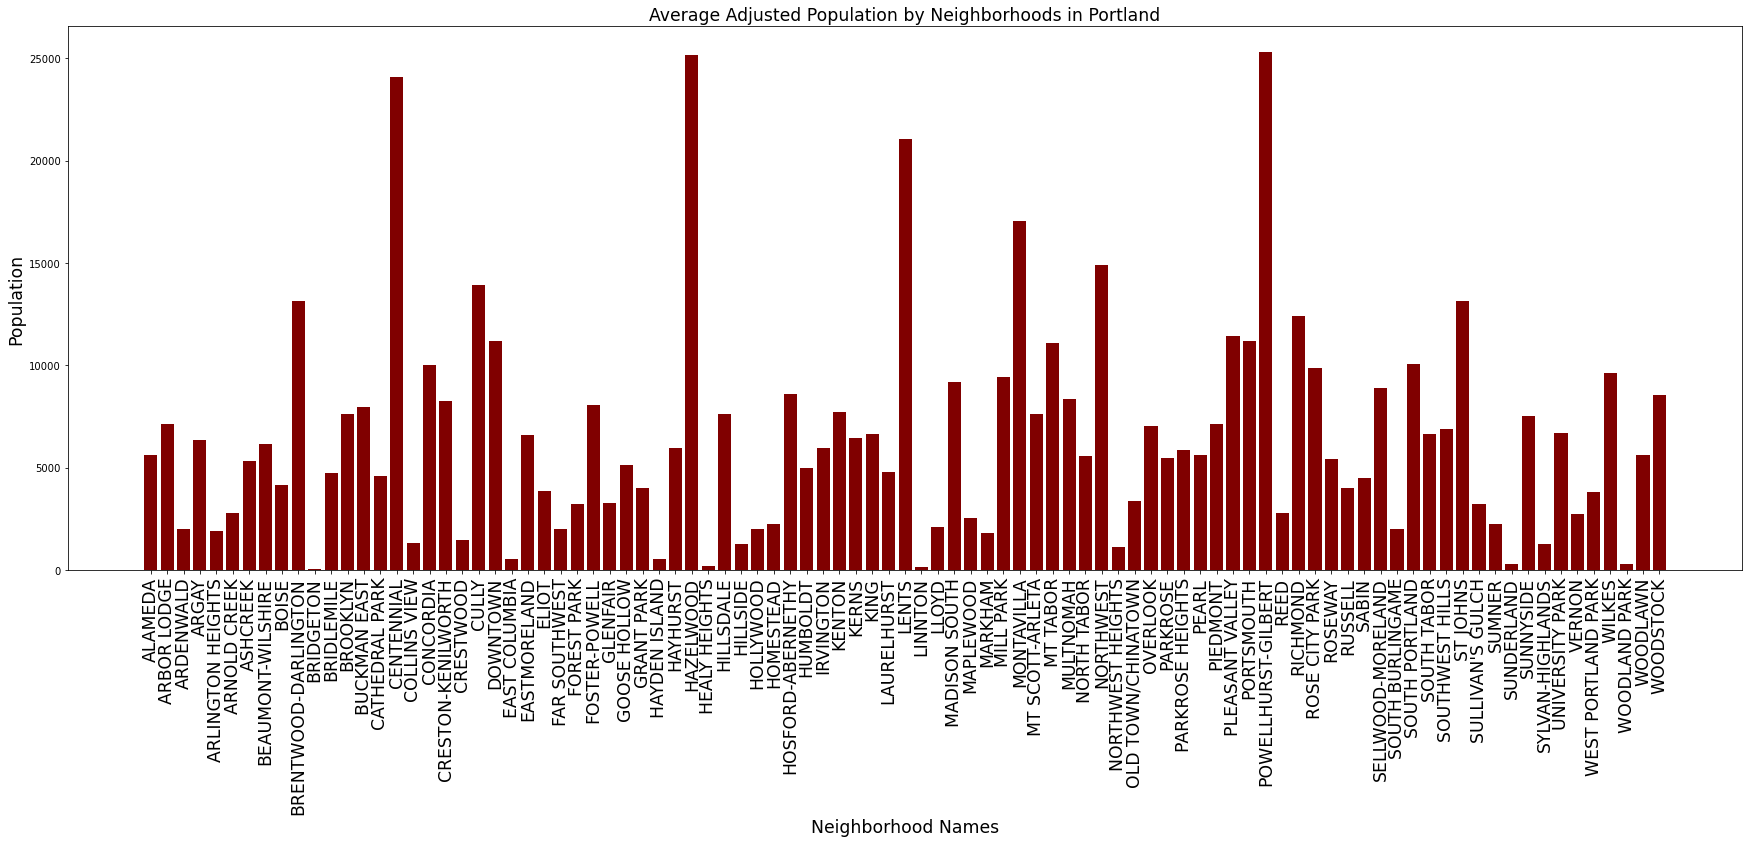

In [6]:
# Create a new column - Year
df_with_controls["Year"] = df_with_controls.OccurMonth_Year.astype(str).str[:-3]
# Group by the dataset by Neighborhood and Year, and average the population for the years 2015 to 2021 by Neighborhood
average_adj_pop_by_neighborhood = df_with_controls.groupby(["Neighborhood", "Year"])["adj_popn"].mean().reset_index()

# Create the figure
fig = plt.figure(figsize = (30, 10))
x = average_adj_pop_by_neighborhood[average_adj_pop_by_neighborhood["Year"] == "2015"]["Neighborhood"]
y = average_adj_pop_by_neighborhood[average_adj_pop_by_neighborhood["Year"] == "2015"]["adj_popn"]
 
# creating the bar plot
plt.bar(x, y, color ='maroon')
 
plt.xlabel("Neighborhood Names", fontsize = "xx-large")
plt.ylabel("Population", fontsize = "xx-large")
plt.title("Average Adjusted Population by Neighborhoods in Portland", fontsize = "xx-large")
plt.xticks(rotation = 90, fontsize = "xx-large")
plt.show()

###  Choropleth Map using Shapefile

In [7]:
# Bringing the names of places in shapefile to the form that is used in crime dataset
list_names = []
for name in shapefile_portland["NAME"]:
    n = name.replace(" ", "_").replace("/", "_").replace(".", "").replace(",", "_")
    list_names.append(n)

# Creating a column to include the updated Names
shapefile_portland["Matched_Names"] = list_names

# Slicing the shapefile_portland dataframe to only include the Names and Geometry of the areas
sliced_shapefile = shapefile_portland[["Matched_Names", "geometry"]].dropna()

#### 1. By Population

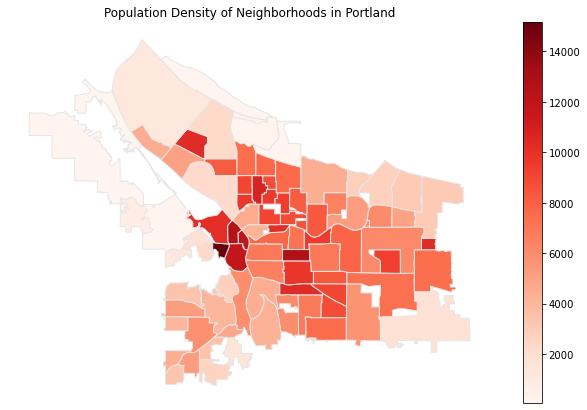

In [9]:
maps.choropleth_by_pop(df_pop= df_with_controls, df_shapefile = sliced_shapefile, by = "interactive")
Image(filename='Figures/pop_density_static.png') 

From the static choropleth map above, it is apparent that the highest density of the population is spread across the south-eastern and north-western parts of the Portland. Let's see below, how the brightnes and the offense rate per $100000$ are spread and whether just by looking at the map, one could derive an apparent insight among them or not.

In [ ]:
# Interactive Choropleth Map for population variable
#maps.choropleth_by_pop(df_pop= df_with_controls, df_shapefile = sliced_shapefile, by = "interactive")
IFrame(src="Figures/population_interactive.html", width = 700, height = 600)

#### 2. By Crime Rate and Year

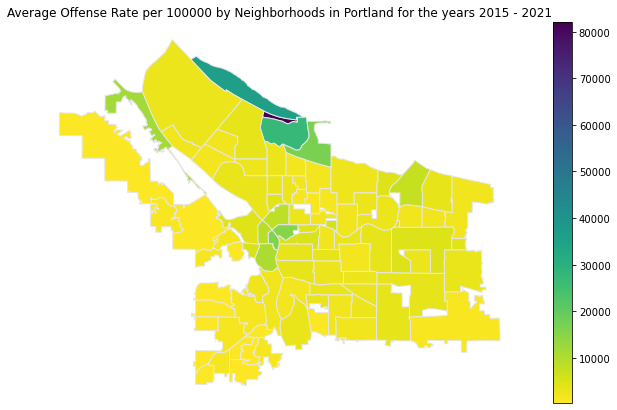

In [12]:
maps.choropleth_by_crime(merged_df = df_with_controls, shapefile = sliced_shapefile,
                        year = None, by = "interactive", type = "average")
Image(filename='Figures/AVECrimeRateper100k_static.png') 

The Offense rate per $100000$ is derived by summing up all types of offenses happened in a certain year and then dividing that value by the adjusted population number, which is then multiplied by $100000$ to get the rate. <br>


#### 3. By Brightness Index and Year

In [15]:
# Generate annual average of brightness index by Neighborhoods in Portland
brightness_index["Year"] = brightness_index.dates.astype(str).str[:4]
brightness_annual_ave = brightness_index.groupby(["Names of Places",
                                                  "Year"])["Average Radiance Per Pixel Per month"].mean().reset_index()

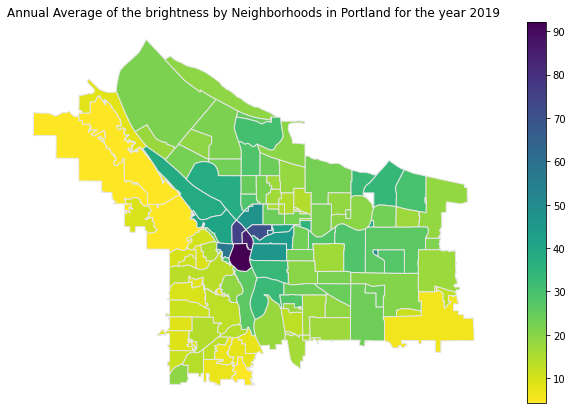

In [16]:
maps.choropleth_by_brightness(df = brightness_annual_ave, shapefile = sliced_shapefile, 
                              year = "2019", by = "interactive")
year = "2019"
Image(filename=f'Figures/Brightness_static{year}.png') 

## 6. Random Forest Regression: Prediction of crime rate  using Brightness Index <a class="anchor" id="rfc"></a>


**Random Forest** is a Machine Learning algorithm that can perform both classification and regression problems with the help of a technique called **bagging**; the idea behind which is to combine the outputs of multiple decision trees and determine the end output. <br>
The problem we will tackle is the prediction of crime rate using brightness index and other controls, given 5 years of past crime and brightness data. This kind of prediction is a supervised regression problem. It is supervised because we do have an access to the past data for both predictor and predicted variables. It is regression-based, since the variable we want to predict is continuous. 

**1st Step: Import the required libraries**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Read the data
df_rf = df_with_controls[['OccurMonth_Year', 'Matched_Names', 'Total_Offenses',
                          'Average Radiance Per Pixel Per month']]
df_rf["Year"] = df_rf.OccurMonth_Year.astype(str).str[:-3]
df_rf["Month"] = df_rf.OccurMonth_Year.astype(str).str[5:]
df_rf["Month"] = [m.replace('0', '') if m[0] == '0'  else m for m in df_rf["Month"].to_list()]
df_rf["Month"] = df_rf["Month"].astype(int)
df_rf["Year"] = df_rf["Year"].astype(int)
                                                                  

# Drop the rows with missing values
df_rf.dropna(inplace = True)

In [ ]:
df_with_controls.columns
'Prostitution Offenses', 'Robbery',
       'Sex Offenses' 'adj_popn_pe_sq_mi'

In [ ]:
df_rf.head()

The description of the variables: <br>
***OccurMonth_Year:*** the year and the month the offense took place. The original dataset supplies the date and timestamp of the specific offense, the above dataset is being cleaned and aggregated for the monthly entries; since the brightness index is monthly aggregate. <br>
***Matched_Names:*** the matched version of the neighborhood names in crime dataset with those in brightness index dataframe, so that the left join of the tables could be operated. <br>
***Total_Offenses:*** the sum of all different types of offenses that took place in the specified month, year and the neighborhood. <br>
***Average Radiance Per Pixel per month:*** our predictor variable, the name of the column is self-explanatory, it stores the derived average radiance per pixel per month. <br>
Now, we will change the Matched_Names column into columns of binary data so that it is computer readable.

In [ ]:
# One-hot encoding the data in Matched_Names Column
df_rf = pd.get_dummies(df_rf)
df_rf.head()

In [ ]:
# We will convert the pandas object to numpy arrays as the algorithm arguments require them to be in array data type
# Total_Offenses is the label we want to predict 
to_be_predicted = np.array(df_rf['Total_Offenses'])
predictors =  df_rf.iloc[:, 2:]
predictors_list = list(predictors.columns)
predictors = np.array(predictors)

In [ ]:
# Import the function to split the data into training and test sets from Skicit-learn 
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_predictors, test_predictors, train_predicted, test_predicted = train_test_split(predictors, to_be_predicted, 
                                                                            test_size = 0.25, 
                                                                            random_state = 30)

In [ ]:
# Initialize the model with 1000 decision trees
random_forest_model = RandomForestRegressor(n_estimators = 1000, random_state = 30)
# Train the model on our training data
random_forest_model.fit(train_predictors, train_predicted)

In [ ]:
# Let's use the trained model on the test data
predictions_rf = random_forest_model.predict(test_predictors)
# Calculate the Absolute Errors
errors_rf = abs(predictions_rf - test_predicted)
# Calculate the Mean Absolute Error (MAE)
print('Mean Absolute Error is:', round(np.mean(errors_rf), 2))


In [ ]:
# Calculate the Mean Absolute Percentage Error (MAPE)
mape_rf = 100 * (errors_rf / test_predicted)
# Calculate and display accuracy
accuracy_rf = 100 - np.mean(mape_rf)
print('Accuracy:', round(accuracy_rf, 2), '%.')